In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpltools import annotation
from scipy.integrate import solve_ivp

from matplotlib import rcParams

# Implicit vs explicit methods

Implicit and explicit methods are used to solve ODE and PDE by approximating the solution based on its derivative. The characteristic differentiating them is that in explicit schemes the state of the solution at each time point can be derived using the state at previous time points whereas for implicit schemes the current state of the solution is written as a function of itself or a future state. 

The simplest example of an explicit scheme is the Forward Euler where the solution can be derived iteratively by updating the next state based on the current state and current derivative. In general, this quality makes explicit schemes easier to implement through a simple time stepping approach. Implicit schemes such as Backward Euler on the other hand are often not self starters - meaning that since the first step of the method requires knowledge of future state, one will need to use an explicit scheme first to calculate the future derivative. They will also be more complicated to implement for systems of differential equations and nonlinear problems. They are generally preferred over explicit schemes for their larger stability regions which allow them to achieve required accuracy quicker, at a bigger time step, or in problems where explicit schemes would require too small of a time step in order to remain stable.

This means that when looking at the choice between explicit and implicit schemes we might want to consider a trade off between accuracy and compitational cost. For an implicit scheme less time steps might be enough to achieve better accuracy due to its stability, but at the same time implementation and computational cost might be higher due to matrix inversions and extra evaluations. When limited by the hardware used or the size of the system to solve, we might want to choose a scheme that's less accurate but less costly to implement.

To demonstrate the accuracy vs evaluations let's first look at a simple example between Forward Euler and Improved Euler. Improved Euler is second order accurate compared to 1st order accurate for Forward Euler, IE actually does 2 evaluations each time step and still requires less evaluations to reach superior accuracy

In [2]:
import matplotlib.pyplot as plt

def dydt(t, y):
    sol = y
    return sol

def y_t(t):
    return np.exp(t) 

def forward_euler(f, y0, t0, tmax, dt):
    y_all = [y0]
    t_all = [t0]
    y = np.array(y0)
    t = np.array(t0)
    
    while t < tmax:
        y = y + f(t, y)*dt
        t = t + dt
        y_all.append(y)
        t_all.append(t)
        
    return np.array(y_all), np.array(t_all)

def improved_euler(f, y0, t0, tmax, dt):
    y_all = [y0]
    t_all = [t0]
    y = np.array(y0)
    t = np.array(t0)
    
    while t < tmax:
        y_ahead = y + f(t, y)*dt
        y = y + 0.5 * dt * (f(t, y) + f(t+dt, y_ahead))
        t = t + dt
        y_all.append(y)
        t_all.append(t)
        
    return np.array(y_all), np.array(t_all)

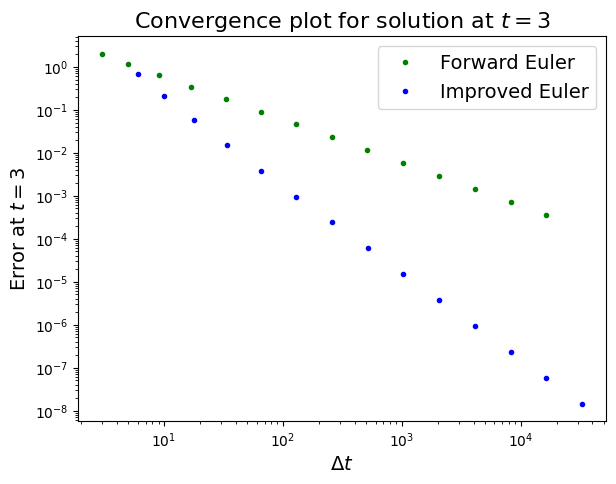

In [3]:
t0 = 0.
tend = 2.
dt = 0.1

y0 = 1
t_fine = np.linspace(0, 2., 1000)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)

evals_fe = []
evals_ie = []
error_fe = []
error_ie = []

dt = 1
while dt > 1e-4:
    states_fe, t_fe = forward_euler(dydt, y0, t0, tend, dt)
    states_ie, t_ie = improved_euler(dydt, y0, t0, tend, dt)
    error_fe.append(np.linalg.norm((states_fe - y_t(t_fe))/np.sqrt(len(t_fe))))
    error_ie.append(np.linalg.norm((states_ie - y_t(t_ie))/np.sqrt(len(t_ie))))
    evals_fe.append(len(t_fe))
    evals_ie.append(len(t_ie)*2)
    dt = dt*0.5
    
ax1.loglog(evals_fe, error_fe, 'g.', label='Forward Euler')
ax1.loglog(evals_ie, error_ie, 'b.', label='Improved Euler')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t=3$', fontsize=14)
ax1.set_title('Convergence plot for solution at $t=3$', fontsize=16);#
ax1.legend(loc='best', fontsize=14);

However, let's look at a more complicated example such as the non stiff problem below. Solving it using explicit vs implicit Runge-Kutta method (RK45 vs Radau from the SciPy package) shows us that while achieving higher accuracy the implicit method also requires more evaluation steps:

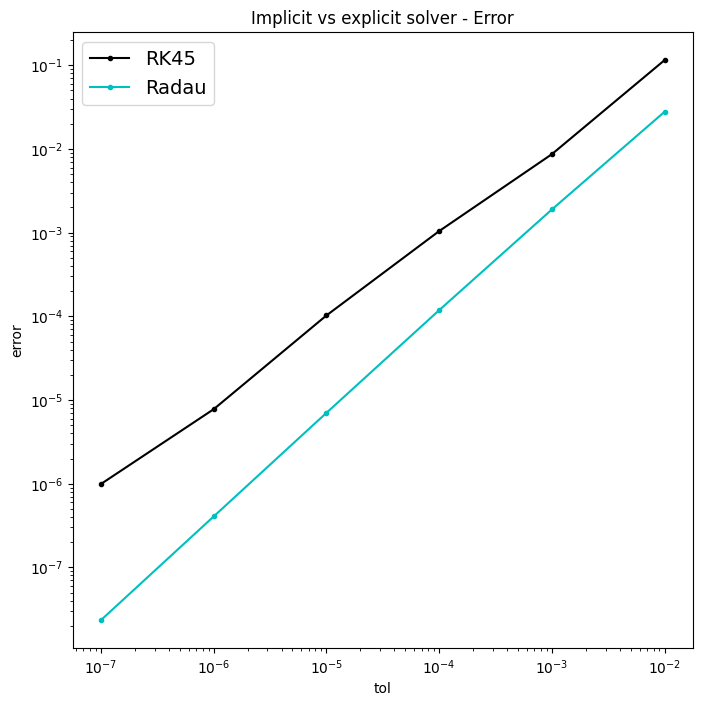

In [4]:
def dydt(t, y):
    return y - t**2 + 1.

def y_ex(t):
    return (t+1)**2 - np.exp(t)/2.

# initial condition
y0 = 0.5

# times we want to get output from ODE solver, use same spacing as
# the dt we use on our own solvers
N = 101
t0 = 0.0
tend = 4.0
ts = np.linspace(t0, tend, N)

tols = np.array([10.**(-p) for p in np.arange(2,8)])

errors_odeint = np.zeros((len(tols)), dtype=float)
errors_rk45 = np.zeros((len(tols)), dtype=float)
errors_rk23 = np.zeros((len(tols)), dtype=float)
errors_lsoda = np.zeros((len(tols)), dtype=float)
errors_bdf = np.zeros((len(tols)), dtype=float)
errors_radau = np.zeros((len(tols)), dtype=float)

for i, tol in enumerate(tols):
    r_tol = tol
    a_tol = tol
    y_solve_ivp_rk45 = solve_ivp(dydt, [t0, tend], np.array([y0]), method='RK45', t_eval=ts, rtol=r_tol, atol=a_tol)
    errors_rk45[i] = np.abs(y_solve_ivp_rk45.y[0][-1] - y_ex(ts[-1]))
    y_solve_ivp_radau = solve_ivp(dydt, [t0, tend], np.array([y0]), method='Radau', t_eval=ts, rtol=r_tol, atol=a_tol)
    errors_radau[i] = np.abs(y_solve_ivp_radau.y[0][-1] - y_ex(ts[-1]))

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.loglog(tols, errors_rk45, 'k.-', label='RK45')
ax1.loglog(tols, errors_radau, 'c.-', label='Radau')
ax1.set_xlabel('tol')
ax1.set_ylabel('error')
ax1.set_title('Implicit vs explicit solver - Error')
ax1.legend(loc='best', fontsize=14);

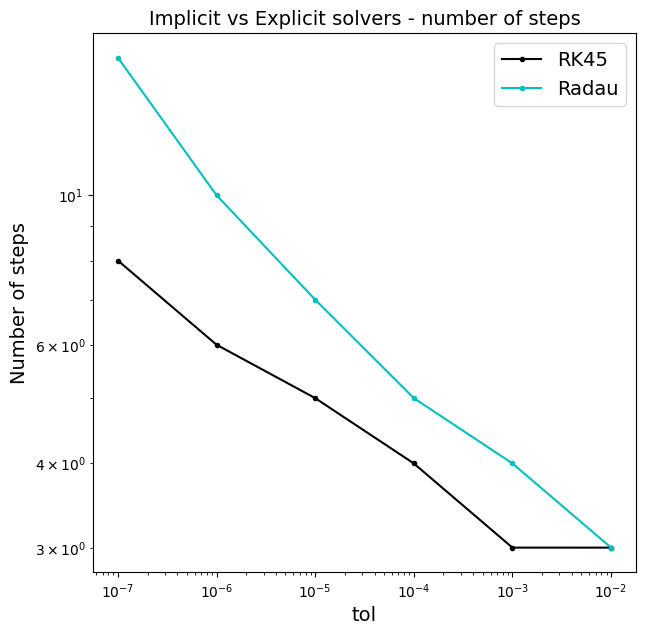

In [5]:
N = 101
t0 = 0.0
tend = 1.0
ts = np.linspace(t0, tend, N)
y0 = 0.5

tols = np.array([10.**(-p) for p in np.arange(2,8)])

steps_rk45 = np.zeros((len(tols)), dtype=float)
steps_radau = np.zeros((len(tols)), dtype=float)

for i, tol in enumerate(tols):
    r_tol = tol
    a_tol = tol
    y_solve_ivp_rk45 = solve_ivp(dydt, [t0, tend], [y0], method='RK45', rtol=r_tol, atol=a_tol)
    steps_rk45[i] = len(y_solve_ivp_rk45.t)
    y_solve_ivp_radau = solve_ivp(dydt, [t0, tend], [y0], method='Radau', rtol=r_tol, atol=a_tol)
    steps_radau[i] = len(y_solve_ivp_radau.t)

    
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))

ax1.loglog(tols, steps_rk45, 'k.-', label='RK45')
ax1.loglog(tols, steps_radau, 'c.-', label='Radau')
ax1.set_xlabel('tol', fontsize=14)
ax1.set_ylabel('Number of steps', fontsize=14)
ax1.set_title('Implicit vs Explicit solvers - number of steps', fontsize=14)
ax1.legend(loc='best', fontsize=14);

From the plot above we can see that actually the explicit RK method shows similar convergence to the implicit scheme. This demonstrates that for certain problems such as the one above an explicit scheme might be a better choice to reduce computational requirements. This is a trade-off that might need to be considered when choosing a method. This also agrees with the advice given by the scipy website - 

"Explicit Runge-Kutta methods (‘RK23’, ‘RK45’, ‘DOP853’) should be used for non-stiff problems and implicit methods (‘Radau’, ‘BDF’) for stiff problems"
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#r179348322575-9

Examining some of the other output parameters for number of evaluation of the Jacobian matrix (0 for explicit) further show the higher computational cost of the implicit scheme

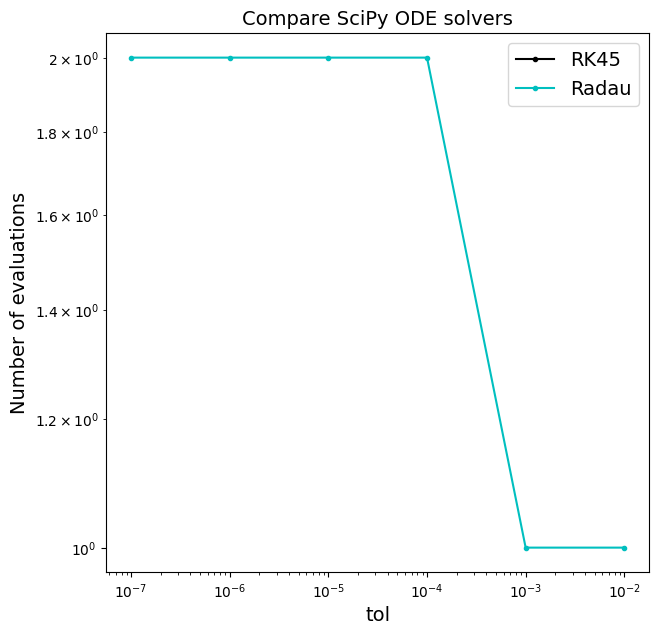

In [6]:
for i, tol in enumerate(tols):
    r_tol = tol
    a_tol = tol
    y_solve_ivp_rk45 = solve_ivp(dydt, [t0, tend], [y0], method='RK45', rtol=r_tol, atol=a_tol)
    # jacobian eval
    steps_rk45[i] = y_solve_ivp_rk45.njev
    y_solve_ivp_radau = solve_ivp(dydt, [t0, tend], [y0], method='Radau', rtol=r_tol, atol=a_tol)
    steps_radau[i] = y_solve_ivp_radau.njev

    
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))

ax1.loglog(tols, steps_rk45, 'k.-', label='RK45')
ax1.loglog(tols, steps_radau, 'c.-', label='Radau')
ax1.set_xlabel('tol', fontsize=14)
ax1.set_ylabel('Number of evaluations', fontsize=14)
ax1.set_title('Compare SciPy ODE solvers', fontsize=14)
ax1.legend(loc='best', fontsize=14);

Now let's show the same comparison for a stiff problem. In this case we can observe that in this explicit RK actually requires way more time steps and even then it does not achieve the same tolerence as the implicit scheme. then for such class problems it would be more favourable to use an implicit scheme which would allow us to use fewer time steps and evaluations

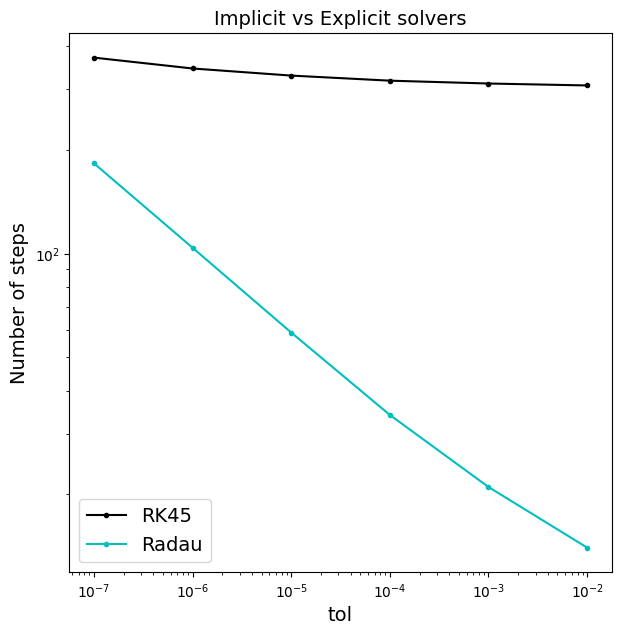

In [7]:
mu = 1000.

def dydt(t, y):
    f = np.zeros_like(y)
    f[0] = y[1]
    f[1] = -mu * y[0] - (mu+1.) * y[1]
    return f

def y_ex(t):
    return 2.*np.exp(-1.*t) - np.exp(-1.*mu*t) 



# initial condition
y0 = np.array([1., mu - 2.])


# times we want to get output from ODE solver, use same spacing as
# the dt we use on our own solvers
N = 101
t0 = 0.0
tend = 1.0
ts = np.linspace(t0, tend, N)

tols = np.array([10.**(-p) for p in np.arange(2,8)])

steps_rk45 = np.zeros((len(tols)), dtype=float)
steps_radau = np.zeros((len(tols)), dtype=float)

for i, tol in enumerate(tols):
    r_tol = tol
    a_tol = tol
    y_solve_ivp_rk45 = solve_ivp(dydt, [t0, tend], y0, method='RK45', rtol=r_tol, atol=a_tol)
    steps_rk45[i] = len(y_solve_ivp_rk45.t)
    y_solve_ivp_radau = solve_ivp(dydt, [t0, tend], y0, method='Radau', rtol=r_tol, atol=a_tol)
    steps_radau[i] = len(y_solve_ivp_radau.t)

    
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))

ax1.loglog(tols, steps_rk45, 'k.-', label='RK45')
ax1.loglog(tols, steps_radau, 'c.-', label='Radau')
ax1.set_xlabel('tol', fontsize=14)
ax1.set_ylabel('Number of steps', fontsize=14)
ax1.set_title('Implicit vs Explicit solvers', fontsize=14)
ax1.legend(loc='best', fontsize=14);

Now, when dealing with systems of equations such as the Lorenz System, implicit schemes require increasingly more evaluations of the Jacobian matrix, which in turn might might increase computational cost

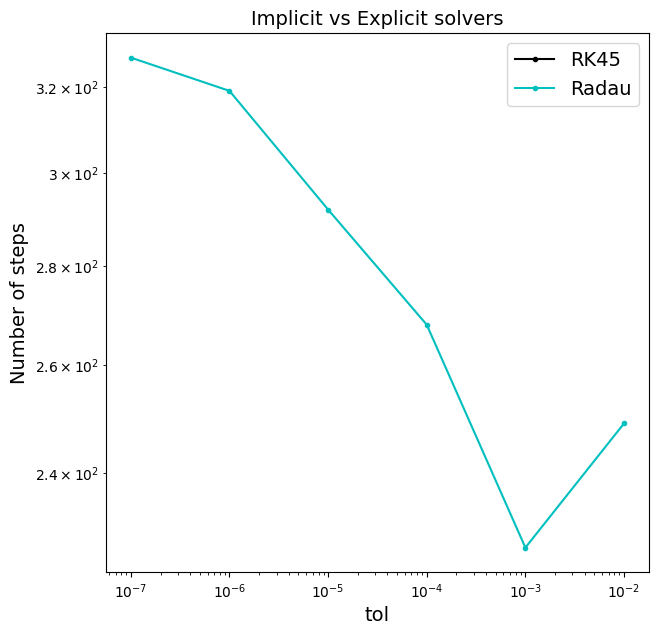

In [8]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def lorenz_system(t, state):
    """ RHS function for Lorenz system
    """
    f = np.zeros_like(state)
    # unpack the state vector
    x, y, z = state  
    f[0] = sigma * (y - x)
    f[1] = x * (rho - z) - y
    f[2] = x * y - beta * z
    return f

# initial condition
y0 = np.array([1.0, 1.0, 1.0])

# times we want to get output from ODE solver, use same spacing as
# the dt we use on our own solvers
dt = 0.01
t0 = 0.
tend = 40.
t = np.arange(t0, tend, dt)

steps_rk45 = np.zeros((len(tols)), dtype=float)
steps_radau = np.zeros((len(tols)), dtype=float)

for i, tol in enumerate(tols):
    r_tol = tol
    a_tol = tol
    y_solve_ivp_rk45 = solve_ivp(lorenz_system, [t0, tend], y0, method='RK45', rtol=r_tol, atol=a_tol)
    steps_rk45[i] = y_solve_ivp_rk45.njev
    y_solve_ivp_radau = solve_ivp(lorenz_system, [t0, tend], y0, method='Radau', rtol=r_tol, atol=a_tol)
    steps_radau[i] =  y_solve_ivp_radau.njev

    
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))

ax1.loglog(tols, steps_rk45, 'k.-', label='RK45')
ax1.loglog(tols, steps_radau, 'c.-', label='Radau')
ax1.set_xlabel('tol', fontsize=14)
ax1.set_ylabel('Number of steps', fontsize=14)
ax1.set_title('Implicit vs Explicit solvers', fontsize=14)
ax1.legend(loc='best', fontsize=14);

# Runge-Kutta vs Linear multistep methods

Runge-Kutta and Linear multistep methods both make use of additional function evaluations at different time steps to achieve higher order accuracy solvers. In the case of LMS, weighted function evaluations from previous time intervals are used to predict the function at the next time step. This requires that at the start several function evaluations at different time intervals must be already be available, making the method not a self starter. Meanwhile RK methods rely on evaluations at differnet time steps but only within the same time interval - between the current step and the future time step. 

One of the implications of these differences is that since the LMS uses previous function evaluations these must be stored between time steps. For the examples in class this was seen as advantage since evaluations had to be stored to be plotted anyway. This meant that increasing the order of the method didn't come with extra memory cost. Meanwhile intermediate evaluations made by the RK method were discarder after each time interval and were essentially lost, while also still storing all the previous function evaluations. An interesting scenario to challange this is when trying to create time-of-flight simulations of large systems with many equations. Storing all previous states would be memory costly and might not be required if only the current state of the system is important. In that case RK4 and LMS of order 4 would require similar memory storage since they would require the same number of evaluations. 
Additionally, the intermediate time evaluation of the Runge-Kutta methods can potentially be parallelised between devices which further facilitates scaling the scheme for large systems.

# Finite difference vs finite element methods

Finite difference is a method for solving differential equations based on the discretisation of the derivatives of the function. Different schemes for this discretisation exist, which inform the relationship between different nodes of the solution function and help us derive a new node from previous function evaluations. This means that our solution will only be defined at the points where function is evaluated.

Finite element methods, on the other hand, discretise the solution of the differential equation through the use of basis functions. The discretisation is equivalent to a piecewise interpolation and is continuous and defined everywhere. The best approximation for the solution is then derived through quadrature. 

As seen in the lectures simple finite difference schemes such as the Forward Euler and Runge-Kutta have been relatively easy to implement. In the case of linear systems explicit finite difference methods a simple time stepping approach was sufficent to solve differential equations, even PDEs such as the advection diffusion equation. Solving for the same problems with FE method would require us to perform a quadrature, which can be computaionally expensive. 

However, we also saw that similar problems can become unstable. In the case of the advection diffusion problem the cell Peclet number which depends on the value of the advection and thermal diffusivity might force us to use finer and finer mesh in order to remain stable. In other words more computational cost can be expected to solve fast-changing, unsteady systems using FD. One solution is the use of non-uniform meshes which can be denser at regions of fast variation and sparser elsewhere. But non-uniform meshes are more difficult to implement with the finite difference method, especially in 2D and 3D. For FD function evaluations are based on discretisations on defined grid with the solution to the diferential equation defined only at the nodes. 